# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 3 ***K***-Nearest Neighbors Classifier ##

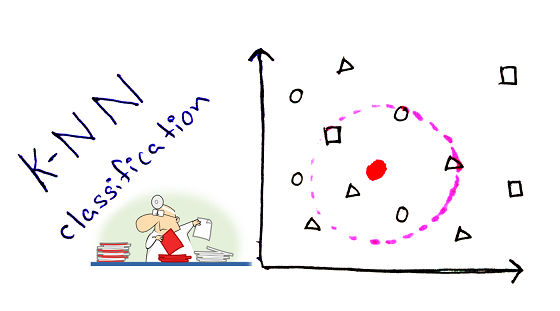

## **Review** ##
Before we start, let's have a quick recap of the lecture.

## ***K*-Nearest Neighbors Classifier** ##
The K-Nearest Neighbors Classifier or <b>***K***NN</b> Classifier algorithm predicts the label of a test sample based on the labels of its <b><i>K "nearest"</i></b> training samples.

* The training samples are composed of features and class labels.

* The <b>"near"</b>-ness of a training sample to the test sample is measured by the <b>distance</b> between their features.

>### What do we mean by distance?
><b>Euclidean distance</b> is a commonly used distance function. For example, let $x^{Train}$ and $x^{Test}$ be the vector representation of features of a training sample and a test sample, respectively. The Euclidean distance between them can be computed as follows: <br />
>$distance(x^{Train}, x^{Test}) =\large \sqrt{\mathrm{\sum_{i=1}^n (x_i^{Train}-x_i^{Test})^2}}$, where $x^{Train} = ( {\mathrm x_1^{Train} }, ...,  {\mathrm x_n^{Train} ) } $, $x^{Test} = ( {\mathrm x_1^{Test} }, ...,  {\mathrm x_n^{Test} ) }. $ <br />
>There are also many other distance metrics, for example, <br />
<b>Manhattan distance</b>: $distance(x^{Train}, x^{Test}) =\large {\mathrm{\sum_{i=1}^n |x_i^{Train}-x_i^{Test}|}}$, <br />
><b>Cosine distance</b>: $distance(x^{Train}, x^{Test}) = 1- \text{cosine similarity} = \Large 1- \frac{x^{Train}\cdot x^{Test}}{\|x^{Train}\|\cdot \|x^{Test}\|} = \large 1- \frac{\sum_{i=1}^n x_i^{Train}x_i^{Test}}{\sqrt{\sum_{i=1}^n (x_i^{Train})^2}\cdot \sqrt{ \sum_{i=1}^n (x_i^{Test})^2}}$. <br /><br />

* This algorithm identifies ***K*** training samples with minimum <b>distances</b> to a testing sample. These are the ***K*-Nearest Neighbors**.

* The <b>predicted label</b> of a testing sample is the label of the majority of its ***K*-Nearest Neighbors**.

* The value of <b><i>K</i></b> is a positive integer. If <b><i>K</i></b> = 1, the predicted output is the class of the nearest neighbor. If <b><i>K</i></b> > 2, the predicted output is based on the majority votes of its ***K*** nearest neighbors from training data.

We will go through the steps of predicting the label of a test sample using ***K***NN.

### **Steps** ###
0. Visualize the data (optional but helpful).
1. Pre-process training data and test data.
2. Select a value of ***K***.
3. Determine which distance function will be used.
4. Compute the distances of the new data to all $n$ training samples.
5. Sort the distances obtained and take the ***K*** nearest data samples.
6. Assign the test sample to the class based on the majority vote of its ***K*** nearest neighbors.

## **Example: Predicting T-shirt sizes** ##

You would like to gift a new friend a T-shirt, but you don't know their size (**label**).

However, you do know their height and weight (**features**).

You also know the heights, weights, and T-shirt sizes of other friends you gave T-shirts to in the past (**training data**).

In [1]:
import numpy as np

## Here is your training data

## Features
height = np.array([157, 155, 154, 153, 161, 156, 159, 154, 164, 159])
weight = np.array([55, 52, 54, 62, 68, 61, 61, 59, 57, 53])

## Labels
size = np.array(['M', 'M', 'M', 'M', 'L', 'M', 'L', 'L', 'L', 'L'])

### **Visualize the data**

We can visualize the data to understand the relationship between height, weight, and T-shirt size.

First, we will plot the training dataset:

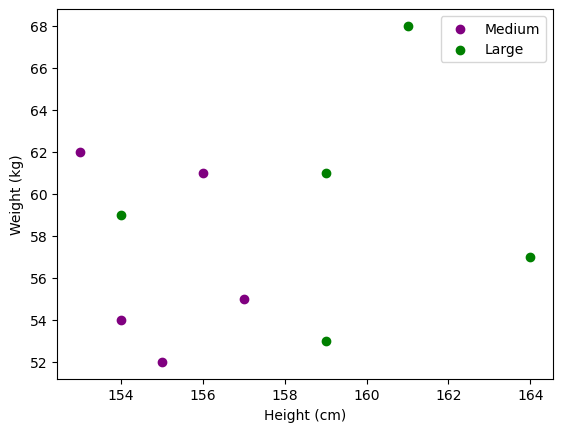

In [2]:
import matplotlib.pyplot as plt

## We can use color to represent T-shirt size:
## Samples with Medium label are purple, Samples with Large label are green

## We can plot each sample on a scatterplot where the horizontal axis is height and the vertical axis is weight
plt.scatter(height[size=='M'], weight[size=='M'], c='purple', label='Medium')
plt.scatter(height[size=='L'], weight[size=='L'], c='green', label='Large')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.legend()
plt.show()

Now, we can plot the test sample:

Let's say your new friend has a height of **154 cm** and a weight of **58 kg**.

We will plot their sample with the training dataset: <font color="red">**the test sample is plotted in red**</font>, while the training samples are plotted in the color of their label (i.e., <font color="green">**green for large**</font> and <font color="purple">**purple for medium**</font>.)

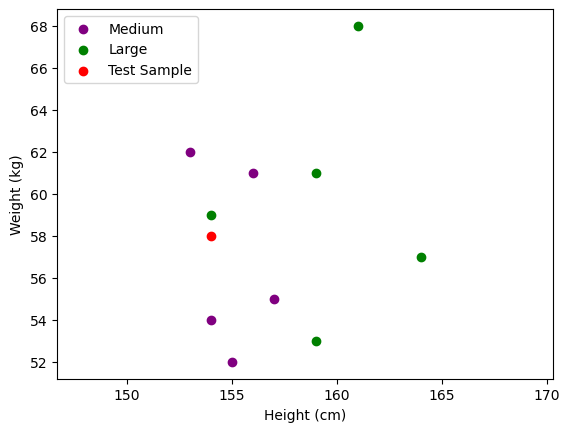

In [3]:
plt.scatter(height[size=='M'], weight[size=='M'], c='purple', label='Medium')
plt.scatter(height[size=='L'], weight[size=='L'], c='green', label='Large')
sample_height, sample_weight = 154, 58
plt.scatter(sample_height, sample_weight, c='red', label='Test Sample')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.legend(loc=2)
plt.axis('equal')
plt.show()

From this plot, you can make the following observations:


*   The nearest training sample to your test sample has the **'large'** label.
*   If ***K*** $ = 1$, the predicted label for the test sample would be **'large'**.
*   Notice that there are more training samples with the **'medium'** label near the test sample, so it may be more likely that the test sample wears **'medium'**.
*   If ***K*** $ = 3$ or higher, the predicted label for the test sample would be **'medium'**.


Now, we can try to get the predicted value using the ***K***NN algorithm.

### **Step 1 - Pre-process training data and test data** ###

A common problem: Features with larger values can dominate classification. (e.g., annual income can be something like **HKD**  $400,000 - 500,000$, but glucose levels will be something like 0.07-0.10 g/dL). In the following example, the prediction result will be visually different if $K=3$. The simple solution is to scale the feature values (e.g., annual income is scaled down, and glucose levels are scaled up).

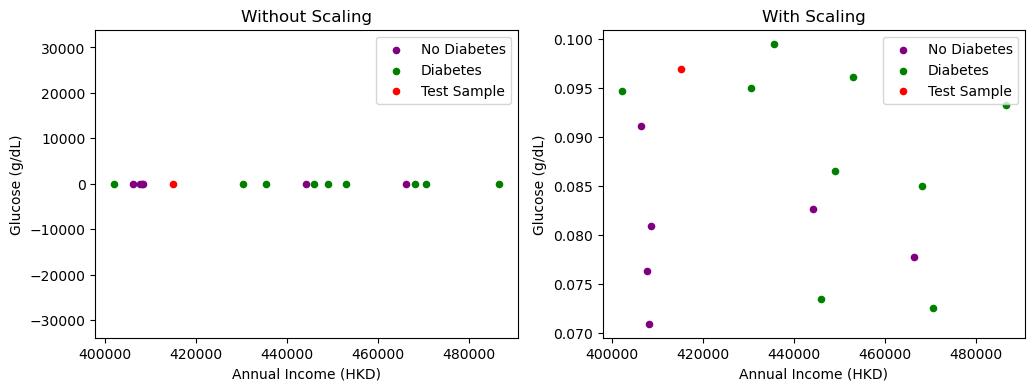

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(15)
annual_income = np.random.randint(400000,500000,15)
glucose = 0.07+0.03*np.random.rand(15)
diabetes = 1-np.random.randint(0,2,15)
sample_income, sample_glucose = 415000, 0.097

def visualize_with_equal_axis(x, y, classes, test_x, test_y, title, xlabel, ylabel, equal=False):
    plt.scatter(x[classes==0], y[classes==0], c='purple', label='No Diabetes', s=20)
    plt.scatter(x[classes==1], y[classes==1], c='green', label='Diabetes', s=20)
    plt.scatter(test_x, test_y, c='red', label='Test Sample', s=20)
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title); plt.legend()
    if equal: plt.axis('equal')

plt.figure(figsize=(12,4))
plt.subplot(121)
visualize_with_equal_axis(annual_income, glucose, diabetes, sample_income, sample_glucose, 'Without Scaling', 'Annual Income (HKD)', 'Glucose (g/dL)', equal=True)
plt.subplot(122)
visualize_with_equal_axis(annual_income, glucose, diabetes, sample_income, sample_glucose, 'With Scaling', 'Annual Income (HKD)', 'Glucose (g/dL)', equal=False)

We can do this through **Standardization**.

Let $\{x_1, x_2, \cdots x_n\}$ be the values of feature $x$ of $n$ training samples.

We can evaluate the sample mean as $\mu_x=\frac 1n \sum_{i=1}^n{x_i}$, and

the sample standard deviation as $\sigma_x=\sqrt{{\sum_{i=1}^n (x_i-\mu_x)^2}/{(n-1)}}$, which is an [unbiased estimator of the population standard deviation](https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation). [This video](https://www.youtube.com/watch?v=D1hgiAla3KI) provides a great explanation.

Then, we can standardize any feature value $x_i$ as follows:

### $x^{new}_i = \frac{x_i - \mu_x}{\sigma_x}$.

Note that the new (test) sample's height <code>test_height</code> and weight <code>test_weight</code> also need to be normalized with respect to the mean and standard deviation of the training samples.




In [5]:
mean_height = height.mean()
stdev_height = height.std(ddof=1) # Note that ddof=1 provides an unbiased estimator of the standard deviation of a hypothetical infinite population.
new_height = (height - mean_height)/stdev_height
test_height = (sample_height - mean_height) / stdev_height

mean_weight = weight.mean()
stdev_weight = weight.std(ddof=1)
new_weight = (weight - mean_weight)/stdev_weight
test_weight = (sample_weight - mean_weight) / stdev_weight

This review will use Scikit-learn's functions to build the ***K***NN models. (Of course, you can still try to build your own!)

Scikit-Learn's *LabelEncoder* converts a vector of label values into integers from $0$ to <code>n_classes</code>$-1$.

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
label = encoder.fit_transform(size)
print("Here are the labels in their original form: ", size)
print("Here are the labels in integer form: ", label)

features = list(zip(new_height, new_weight)) # Standardized data
print("Here are the features in tuple form: ", tuple(features))

## Note: The zip() function converted the two lists into a zip object.
## The zip object is an iterator of tuples where the first item in each passed list is paired together,
## and then the second item in each passed list are paired together, and so on.

Here are the labels in their original form:  ['M' 'M' 'M' 'M' 'L' 'M' 'L' 'L' 'L' 'L']
Here are the labels in integer form:  [1 1 1 1 0 1 0 0 0 0]
Here are the features in tuple form:  ((-0.05679618342470326, -0.6448910578805516), (-0.6247580176717681, -1.2494764246435681), (-0.9087389347953005, -0.8464195134682236), (-1.1927198519188331, 0.7658081312331537), (1.0791274850694266, 1.9749788647591866), (-0.3407771005482357, 0.5642796756454815), (0.5111656508223617, 0.5642796756454815), (-0.9087389347953005, 0.16122276447013717), (1.9310702364400238, -0.24183414670520717), (0.5111656508223617, -1.047947969055896))


### **Steps 2 and 3 - Select a value of *K*, and determine which distance function will be used.** ###

Now, we can use Scikit-Learn's *KNeighborsClassifier* to build the KNN model.

In *KNeighborsClassifier*, we can specify the model parameters like ***K*** and the **distance metric** (e.g., Euclidean distance, Manhattan distance).

The following steps will demonstrate what we can do after fitting the model.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

K = 1
distance = 'euclidean'

model = KNeighborsClassifier(n_neighbors=K, metric=distance)

### **Step 4 - Compute the distance between the test sample and the *K*-training samples** ###

Scikit-Learn's ***KNeighborsClassifier*** conveniently includes a function for computing the distances between test sample(s) and the ***K*** nearest neighbors.

We can obtain the distances using the *kneighbors* method:

><code>K_distances, K_idx = model.kneighbors(X=[[test_height, test_weight]], <b><u>return_distance=True</u></b>) </code> <br /><br />
>Note that <b><u>return_distance=True</u></b> is necessary to get the distances.

*   **K_distances** is a 2D-array of distances between test samples and the ***K*** nearest neighbors.
*   **K_idx** is a 2D-array of indexes of the ***K*** nearest neighbors of test samples.

In [8]:
K = 3
model = KNeighborsClassifier(n_neighbors=K)

features = np.array(features) # Standardized data
label = np.array(label)

model.fit(features, label)

K_distances, K_idx = model.kneighbors(X=[[test_height, test_weight]], return_distance=True)

print(f"The {distance} distance of the test sample from the training samples are", K_distances)

print(f"The labels of the {K} training samples closest to the test sample are", np.take(size, K_idx).tolist())

## Note: np.take(size, K_idx) replaces indices in `K_idx` with their corresponding elements in `size`.

The euclidean distance of the test sample from the training samples are [[0.20152846 0.80611382 0.82952041]]
The labels of the 3 training samples closest to the test sample are [['L', 'M', 'M']]


### **Step 5 - Count the votes of the *K* nearest neighbors** ###

When ***K*** $= 3$, two of the nearest training samples are labeled 'M' and only one is labeled 'L'.

We can specify how to count the neighbors' "votes":
>model = KNeighborsClassifier(n_neighbors=k, metric=distance, <b><u>weights='uniform'</u></b>)

If **weights='uniform'**, the model would count the number of samples for each label (i.e., uniform weight for each sample). In this case, the predicted label would be 'M'.

If **weights='distance'**, the model would base its prediction on the count weighted by the inverse of the distance between the test sample and the neighbors.



In [9]:
def knn_predict(K, distance, weights_type):

    model = KNeighborsClassifier(n_neighbors=K, metric=distance, weights=weights_type)
    model.fit(features, label)
    predicted = model.predict([[test_height, test_weight]])
    predicted = encoder.inverse_transform(predicted)

    print(f"If K={K}, distance={distance}, weights={weights_type}, KNN predicts the label {predicted[0]}.")
    ## predicted[0] is a simple way to convert predicted (a list containing only one string) into a string

knn_predict(K=3, distance='euclidean', weights_type='uniform')

If K=3, distance=euclidean, weights=uniform, KNN predicts the label M.


In the code above, you can change the value of <code>K, distance</code> and <code>weights_type</code>. Different combinations of values for these parameters will result in different predictions.

*   Try { ***K*** = 1 ; weights_type = 'uniform' } vs. { ***K*** = 3 ; weights_type = 'uniform' } to compare our visual method with this algorithmic method.

*   Try { ***K*** = 3 ; weights_type = 'uniform' } vs. { ***K*** = 3 ; weights_type = 'distance' } to see the effect of weighting.

## **Breaking Ties in *K*NN** (Covered in PA1) ##
When applying the ***K***NN classifier, sometimes ties occur. You might get very different prediction results if you choose different breaking methods. In the following, we will introduce several strategies to break ties in ***K***NN. Note that it is hard to say which strategy is better. Usually, it depends on the specific data and the specific problem. Here, we just provide the strategies to consider when dealing with ties.

### **Ties during Neighbor Selection (Equal distance)**
A tie can occur when two or more points are equidistant from an unclassified observation, making it difficult to choose which neighbors are included. In this case, we can consider the following ways to break the tie:
1. Choose a different ***K***. This is a very easy way to break the tie but may result in a non-optimal ***K*** value.
2. Randomly choose between the tied values.
3. Allow observations until the natural stop point. The idea here is to choose the smallest number such that ***K*** is greater than or equal to two and that no ties exist. Note that this method would choose as many values as necessary to avoid the tie.

### **Ties during Classification (Equal number of votes)** ###
Assume we settled on the ties during neighbor selection, but another tie comes out when classifying our unclassified points. There are several methods to break the ties during classification:
1. Choose an odd ***K***.
  * Again, simply choosing an odd value for ***K*** may result in a non-optimal ***K*** value.
  * Furthermore, this method does not always work. The effectiveness can only be guaranteed for binary classification.
2. Randomly select between tied neighbors.
3. Weighted by distance. It is possible to weigh the neighbors so those nearest to the unobserved point have a “greater vote”. This method seems to address most scenarios, although it is still possible it won’t solve every issue.

The most important thing is to **know your data well** and **choose the most appropriate method for your use case**.